# **Klasifikasi Cat & Dog Menggunakan CNN**

<p align="center">
  <a href="url"><img src="https://irp-cdn.multiscreensite.com/05c0ce67/dms3rep/multi/160418893.jpg" align="middle" height="383" width="640" ></a>
</p>

# Bagaimana Membuat Fully-Connected Image Classifier


Kita akan melatih sebuah fully-connected neural network untuk melakukan image classification Kucing dan Anjing. KIta akan menggunakan Framework Deep Learning TensorFlow untuk membuat neural network dan training/validation dataset. Pertama, silahkan download training and validation data.


# **1. Import Library**

Pengolahan Data

In [ ]:
import os
import zipfile

Visualisasi

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as img
import cv2 as cv

Modelling

In [ ]:
# Preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Modelling
import tensorflow as tf
import numpy as np
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

# **2. Data Understanding**

## **2.1 Download Dataset**

In [ ]:
!wget https://storage.googleapis.com/tensorflow-1-public/course2/cats_and_dogs_filtered.zip

--2022-12-05 06:36:57--  https://storage.googleapis.com/tensorflow-1-public/course2/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.125.128, 64.233.189.128, 108.177.97.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.125.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M  21.9MB/s    in 3.0s    

2022-12-05 06:37:01 (21.9 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



# **2.2 Extract Dataset**

In [ ]:
zip_ref = zipfile.ZipFile("./cats_and_dogs_filtered.zip", 'r')
zip_ref.extractall("tmp/")
zip_ref.close()

## **2.3 Menata Folder Dataset**

In [ ]:
base_dir = 'tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Folder data latih Kucing
train_cats_dir = os.path.join(train_dir, 'cats')

# Folder data latih anjing
train_dogs_dir = os.path.join(train_dir, 'dogs')

# folder data testing kucing
validation_cats_dir = os.path.join(validation_dir, 'cats')

# folder data testing anjing
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

Melihat seperti apa nama file di training directory `Cat` dan `Dog` :

In [ ]:
train_Cat_names = os.listdir(train_cats_dir)
print(train_Cat_names[:10])

train_Dog_names = os.listdir(train_dogs_dir)
print(train_Dog_names[:10])

validation_Cat_hames = os.listdir(validation_cats_dir)
print(validation_Cat_hames[:10])

validation_Dog_names = os.listdir(validation_dogs_dir)
print(validation_Dog_names[:10])

['cat.749.jpg', 'cat.360.jpg', 'cat.277.jpg', 'cat.799.jpg', 'cat.478.jpg', 'cat.426.jpg', 'cat.746.jpg', 'cat.823.jpg', 'cat.285.jpg', 'cat.506.jpg']
['dog.639.jpg', 'dog.913.jpg', 'dog.399.jpg', 'dog.850.jpg', 'dog.578.jpg', 'dog.752.jpg', 'dog.423.jpg', 'dog.417.jpg', 'dog.30.jpg', 'dog.409.jpg']
['cat.2118.jpg', 'cat.2115.jpg', 'cat.2238.jpg', 'cat.2485.jpg', 'cat.2225.jpg', 'cat.2018.jpg', 'cat.2099.jpg', 'cat.2250.jpg', 'cat.2220.jpg', 'cat.2025.jpg']
['dog.2129.jpg', 'dog.2140.jpg', 'dog.2063.jpg', 'dog.2238.jpg', 'dog.2496.jpg', 'dog.2416.jpg', 'dog.2184.jpg', 'dog.2430.jpg', 'dog.2038.jpg', 'dog.2225.jpg']


Mencari informasi berapa total images dari cat dan dog di directory :

In [ ]:
print('total training Cat images:', len(os.listdir(train_cats_dir)))
print('total training Dog images:', len(os.listdir(train_dogs_dir)))
print('total validation Cat images:', len(os.listdir(validation_cats_dir)))
print('total validation Dog images:', len(os.listdir(validation_dogs_dir)))

total training Cat images: 1000
total training Dog images: 1000
total validation Cat images: 500
total validation Dog images: 500


## **2.4 Visualisasi Dataset**

Melihat beberapa pictures untuk mendapatkan sense lebih baik Seperti apa.
Hal pertama yang dilakukan adalah melakukan konfigurasi matplot parameters:

In [ ]:
%matplotlib inline

# Parameter untuk grafik kita; kita akan menampilkan gambar dalam konfigurasi 4x4
nrows = 4
ncols = 4

# Indeks untuk looping gambar
pic_index = 1

Menampilkan 8 batch dari 8 Cat and 8 Cat pictures. Kamu bisa melakukan rerun cell kembali untuk melihat fresh batch setiap waktu:

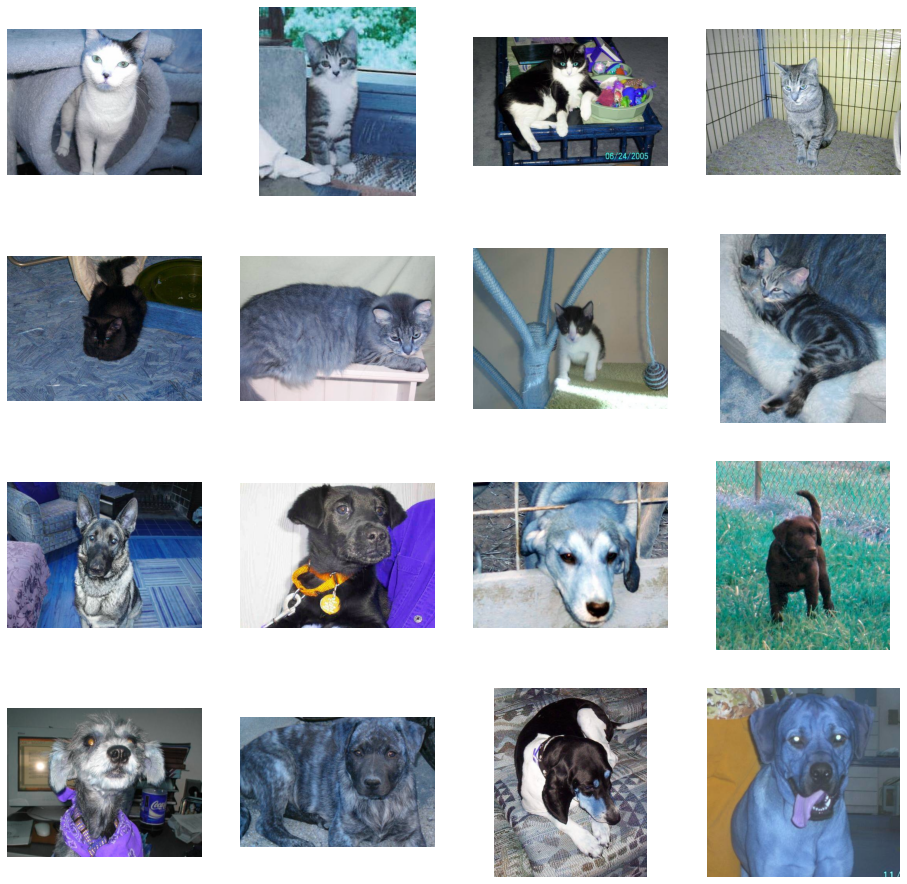

In [ ]:
# Siapkan gambar matplotlib, dan sesuaikan ukurannya dengan gambar 4x4
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_Cat_pic = [os.path.join(train_cats_dir, fname)
                for fname in train_Cat_names[pic_index-8:pic_index]]
next_Dog_pic = [os.path.join(train_dogs_dir, fname)
                for fname in train_Dog_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_Cat_pic + next_Dog_pic):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  im = cv.imread(img_path)
  plt.imshow(im)

plt.show()


#### Data Preprocessing

Menggunakan `keras.preprocessing.image.ImageDataGenerator` class untuk membuat  train and validation dataset dan normalize data.
Sangat penting untuk melakukan normalize data karena data akan diproses oleh CNN untuk improve performance secara keseluruhan. Disini kita akan menggunakan `rescale` parameter untuk scale our image pixel values dari [0, 255] ke [0,1].

Disetiap generator, kita menentukan source directory dari images, classes, input image size, batch size (seberapa banyak images yang akan diproses), dan class mode.

In [ ]:
# Semua gambar akan diubah skalanya menjadi 1./255
train_datagen = ImageDataGenerator(rescale=1/255)
validation_datagen = ImageDataGenerator(rescale=1/255)

# Definisikan gambar pelatihan dalam 120 batch menggunakan generator train_datagen
train_generator = train_datagen.flow_from_directory(
        '/content/tmp/cats_and_dogs_filtered/train/',
        classes = ['cats', 'dogs'],
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

# Definisikan gambar pelatihan dalam 19 batch menggunakan generator train_datagen
validation_generator = validation_datagen.flow_from_directory(
        '/content/tmp/cats_and_dogs_filtered/validation/',
        classes = ['cats', 'dogs'],
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary',
        shuffle=False)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Menvisualisasikan Dataset

(20, 150, 150, 3)


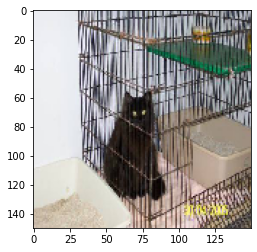

(20, 150, 150, 3)


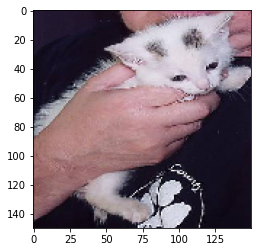

(20, 150, 150, 3)


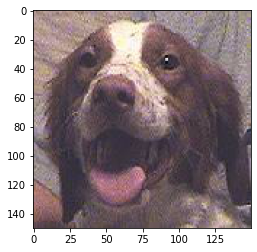

(20, 150, 150, 3)


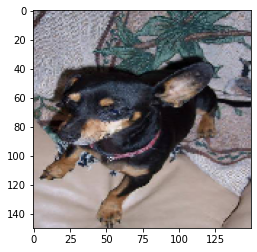

(20, 150, 150, 3)


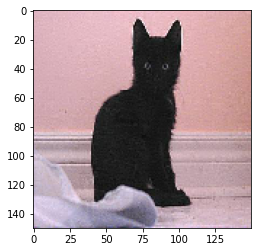

In [ ]:
for _ in range(5):
    img, label = train_generator.next()
    print(img.shape)   #  (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

# **3. Modelling**


## **3.1 Mendefiniskan Arsitektur CNN**

Menambahkan Conv2D layer akan mengoperasikan convolution pada layer tersebut, nilai stride dideskripsikan menggunakan 2 Dimensi meskipun dimensi stride tidak wajib sama misal 3,2 atau 4,5 dll. Pada layer convolution jumlah trainable parameter bukan menjadi jumlah neuron per layer  tapi hanya menunjukkan jumlah channel dan bobot per neuron. Parameter padding digunakan jika kita ingin jumlah neuron per channel sama dengan jumlah pixel citra, parameter 'same' menghasilkan padding yang diperlukan agar jumlah neuron=jumlah pixel. Jumlah neuron pada layer Conv2D tidak dideskripsikan karena sudah dideskripsikan oleh parameter lain, contoh: kombinasi padding='same' dan stride=(2,2) menghasilkan neuron separuh dari jumlah total pixel(ukuran gambar 200X200 3 channel->jumlah total pixel=120000, maka jumlah neuron akan menjadi 60000)
Menambahkan Flatten layer yang akan mem-flatten input image, dimana akan dilanjutkan ke next layer, Dense layer, atau fully-connected layer, dengan 128 hidden units, Flatten layer pada model ini tidak memerlukan input size karena sudah dideskripsikan pada Conv2D layer pertama
Pada tujuan akhirnya adalah untuk  melakukan binary classification, final layer akan menggunakan sigmoid, jadi output dari neural network akan menjadi single scalar antara 0 and 1, dengan melakukan encoding  probability pada image saat ini dengan class
(class 1 menjadi dog dan class 0 menjadi cat).

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 34, 34, 64)        36928     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 17, 17, 64)      

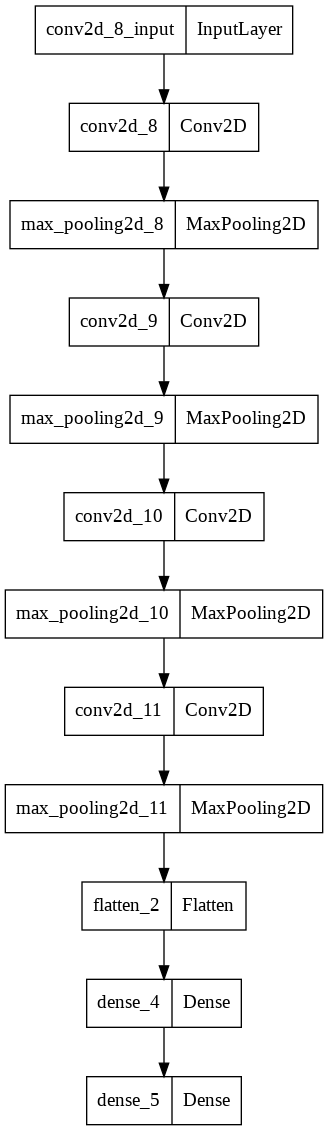

In [ ]:
tf.keras.utils.plot_model(model)

Kolom "output shape"  menampilkan transformasi dari setiap dimensi layer sebagai hasil dari convolution and max pooling - convolution akan mengurangi layer size sedikit karena proses padding, dan max pooling membagi 2 output size.

## **3.2 Konfigurasi Spsifikasi Model atau Compile Model**

Konfugirasi specifications untuk model training. Kita akan melakukan train model dengan `binary_crossentropy` loss. Kemudian menggunakan `Adam` optimizer. [Adam](https://wikipedia.org/wiki/Stochastic_gradient_descent#Adam) adalah sensible optimization algorithm karena mengautomasi learning-rate tuning untuk kita (alternatifnya, kita bisa menggunakan [RMSProp](https://wikipedia.org/wiki/Stochastic_gradient_descent#RMSProp) atau [Adagrad](https://developers.google.com/machine-learning/glossary/#AdaGrad) untuk hasil yang serupa). Kita akan menambahkan accuracy ke `metrics` jadi model akan memonitor accuracy saat melakukan training

In [ ]:
from tensorflow.keras.optimizers import Adam, RMSprop

In [ ]:
model1.compile(optimizer = Adam(learning_rate=0.0001),
              loss = 'binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model2.compile(optimizer = RMSprop(learning_rate=0.0001),
              loss = 'binary_crossentropy',
              metrics=['accuracy'])

## **3.3 Training**
Lakukan training dengan 15 epochs.

Perhatikan steps_per_epoch ditetapkan bersamaan dengan batch_size di ImageDataGenerator jadi steps_per_epoch * batch_size = total # of images.
Sebagai contohnya, untuk training, 20 * 100 = 2000, dengan total 2000 images.

Perhatikan saat kita melakukan training, validation accuracy tidak pernah melebihi training accuracy, dimana ini adalah sesuatu yang baik. Model tidak akan bekerja lebih baik pada data images yang belum terlihat dibandingkan images yang telah terlihat.

In [ ]:
history = model.fit(train_generator, # Total gambar training = batch_size_training * steps_per_epochs = 2000
      steps_per_epoch=100,
      epochs=20,
      verbose=1,
      validation_data = validation_generator,
      validation_steps=50) # Total gambar testing = batch_size_validation * validation_steps = 1000


## **3.5 Evaluasi Model**

Evaluasi accuracy model:

In [ ]:
model.evaluate(validation_generator)

Kalkulasi ROC curve dan lakukan plotting.

Lakukan prediction di validation set. Ketika menggunakan generators untuk membuat predictions, Kita matikan shuffle (seperti yang kita lakukan ketika kita membuat validation_generator) dan reset the generator:

In [ ]:
STEP_SIZE_TEST=validation_generator.n//validation_generator.batch_size
validation_generator.reset()
preds = model.predict(validation_generator,
                      verbose=1)

Untuk membuat ROC curve dan AUC, kita harus menghitung false-positive rate dan  true-positive rate:

In [ ]:
fpr, tpr, _ = roc_curve(validation_generator.classes, preds)

In [ ]:
roc_auc = auc(fpr, tpr)

In [ ]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

ROC curve probabilitas yang memplot tingkat true-positive rate (TPR) terhadap false-positive rate (FPR). didalam kurva ini, garis diagonal adalah kurva untuk random guessing, seperti coin flipping, jadi ROC curve di atas menunjukkan bahwa model lebih baik daripada kemungkinan melakukan classifying diantara cat dan dog. GOOD!

Demikian pula, AUC (area di bawah kurva), seperti yang ditunjukkan pada legend di atas, mengukur seberapa banyak model untuk mampu membedakan antara dua kelas, cat dan dog. Semakin tinggi AUC, semakin baik model kami dalam klasifikasi.

Plotting keseluruhan Hasil Model

In [ ]:
def plot_loss_acc(history):
  '''Plots the training and validation loss and accuracy from a history object'''
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'bo', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')

  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training Loss')
  plt.plot(epochs, val_loss, 'b', label='Validation Loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

In [ ]:
model.save('model_2.h5')

## Making Predictions
Menggunakan model untuk melakukan predictions! Upload sebuah gambar untuk melihat apakah cat atau dog.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from keras.preprocessing import image

from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():

  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150, 1501))
  x = image.img_to_array(img)
  plt.imshow(x/255.)
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]<0.5:
    print(fn + " ini adalah Kucing")
  else:
    print(fn + " ini adalah Anjing")


## Clean Up
Run the following cell to terminate the kernel and free memory resources:

In [ ]:
import os, signal
os.kill(os.getpid(), signal.SIGKILL)

# Activity

1. Ikuti langkah langkah yang sudah di berikan
2. Ganti model neural network di atas dengan arsitektur CNN

Berikut adalah arsitektur dari CNN, bandingkan hasilnya


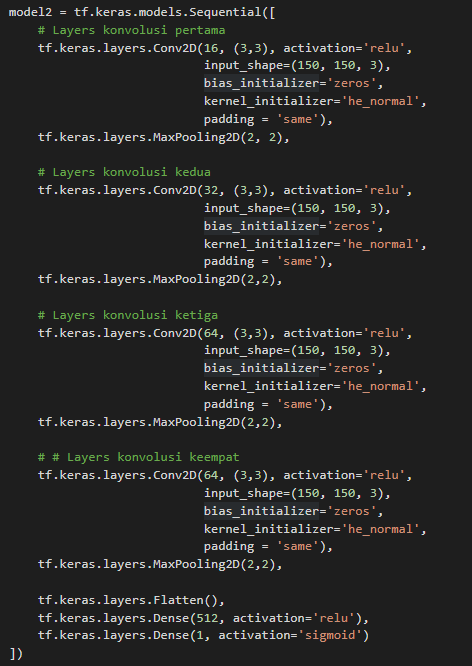

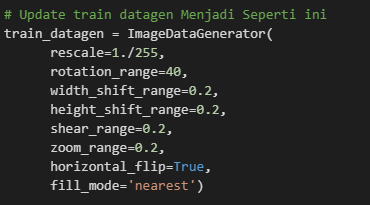